(array([[<AxesSubplot:title={'center':'steering'}>]], dtype=object),
             throttle       steering
 count  102176.000000  102176.000000
 mean        0.577268      -0.007161
 std         0.475320       0.113447
 min         0.000000      -1.000000
 25%         0.000000      -0.073310
 50%         1.000000      -0.007634
 75%         1.000000       0.063397
 max         1.000000       1.000000)

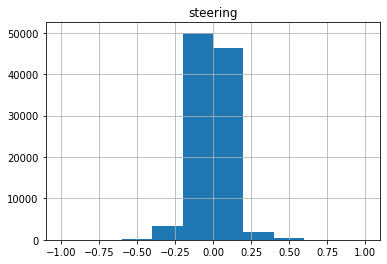

In [4]:
throttles, steerings = [], []
for st_path in veh_state_paths:
    array = np.load(st_path)
    throttles.append(array[-2])
    steerings.append(array[-1])
df = pd.DataFrame(
    data={"throttle":throttles, "steering":steerings}
)
df.hist("steering"), df.describe()

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
import os
import torch.utils.data as data
import matplotlib.pyplot as plt


In [9]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
#from torchnet.meter import AverageValueMeter
import torch.backends.cudnn as cudnn

In [10]:
data_dir = Path("/home/michael/Desktop/projects/ROAR/data/output")
center_depth_dir = data_dir / "front_depth"
veh_state_dir = data_dir / "vehicle_state"

center_depth_paths = [p for p in sorted(center_depth_dir.glob("*.npy", ), key=os.path.getmtime)]
veh_state_paths = [p for p in sorted(veh_state_dir.glob("*.npy", ), key=os.path.getmtime)]
print(f"Found { len(center_depth_paths)} data points")

Found 102172 data points


In [11]:
from utils import depth2colorjet, random_flip, crop_roi
import cv2
class CarDataset(data.Dataset):
    def __init__(self, X, y, img_width=64, img_height=64, should_take_roi=False, roi_min_height=30):
        self.X = X
        self.y = y
        self.img_width=img_width
        self.img_height=img_height
        self.should_take_roi = should_take_roi
        self.roi_min_height = roi_min_height
        
    def __getitem__(self, index):
        img_path = self.X[index]
        veh_state_path = self.y[index]
        steering_angle = np.load(veh_state_path)[-1]
        img = np.load(img_path)
#         color_jet_rgb = depth2colorjet(img)
#         img = cv2.resize(img, dsize=(self.img_width, self.img_height))
        if self.should_take_roi: # will not enter
            img = img[30:self.img_width, :]
        
        # generate random noise to the image
        img, steering_angle = random_flip(img, steering_angle)
        return img, steering_angle
    
    def __len__(self):
        return len(self.X)

    

In [12]:
car_dataset = CarDataset(X=center_depth_paths, y=veh_state_paths)


(<matplotlib.image.AxesImage at 0x7f668171a520>, -0.06670547276735306)

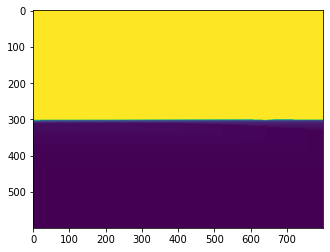

In [13]:
color_jet_depth, angle = car_dataset[100]
plt.imshow(color_jet_depth), angle

In [14]:
class CarModel(nn.Module):
    def __init__(self):
        super(CarModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=24, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(),
            
            nn.Conv2d(24, 48, 5),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(),
            
            nn.Conv2d(48, 96, 5),
            nn.MaxPool2d(2),
            nn.ELU(),
            nn.Dropout(p=0.5)
        )
        self.linear_layers = nn.Sequential(
            nn.LazyLinear(out_features=256),
            nn.Dropout(),
            nn.ELU(),
            
            nn.Linear(in_features=256, out_features=256//2),
            nn.Dropout(),
            nn.ELU(),
            
            nn.Linear(in_features=256//2, out_features=256//4),
            nn.ELU(),
            nn.Linear(in_features=256//4, out_features=1)
        )

    def forward(self, input):
        input = torch.reshape(input, (1, 1, 600,800))
        output = self.conv_layers(input)
        output = output.flatten()
        output = self.linear_layers(output)
        return output   

In [15]:
def toTensor(data, use_cuda, device=None):
    img, target = data
    img, target = torch.from_numpy(img).float(), torch.from_numpy(np.array([target])).float()
    if use_cuda:
        img, target = img.to(device), target.to(device)
    return img, target

In [16]:

def train(epoch, net, dataloader, optimizer, criterion, use_cuda, device=None, save_dir=Path(".")):
    min_error = 1000000
    save_dir.mkdir(exist_ok=True, parents=True)
    if use_cuda:
        net.to(device)
    net.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        # data  = (img, steering_angle)
        optimizer.zero_grad()
        img, steering_angle = toTensor(data, use_cuda, device)
        output = net(img) # Tensor([ITEM])
        loss = criterion(output, steering_angle)
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()
        if batch_idx % 1000 == 0:
            print(f'    Batch: {batch_idx} --> Loss: {train_loss / (batch_idx+1)}')
        
        if train_loss / (batch_idx+1) < min_error:
            print("          Newest lowest steer MSE: {:.4f}".format(train_loss / (batch_idx+1)))
            torch.save(net, save_dir / "best_model.h5")
            min_error = train_loss / (batch_idx+1)
    
    torch.save(net, save_dir / "model.h5")

        

In [17]:
net = CarModel()
optimizer = optim.Adam(net.parameters(), lr=1e-5)
use_cuda = torch.cuda.is_available()
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

/home/michael/anaconda3/envs/ROAR3.8/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [18]:
for epoch in range(0, 10):
    print(f"Epoch {epoch}")
    train(epoch, net, car_dataset, optimizer, criterion, use_cuda, device=device, save_dir=Path("./data"))

Epoch 0
    Batch: 0 --> Loss: 0.007554801646620035
          Newest lowest steer MSE: 0.0076
          Newest lowest steer MSE: 0.0057
    Batch: 1000 --> Loss: 0.011169368111705475
    Batch: 2000 --> Loss: 0.007142928606595718
          Newest lowest steer MSE: 0.0057
          Newest lowest steer MSE: 0.0057
          Newest lowest steer MSE: 0.0057
          Newest lowest steer MSE: 0.0057
          Newest lowest steer MSE: 0.0057
          Newest lowest steer MSE: 0.0056
          Newest lowest steer MSE: 0.0056
          Newest lowest steer MSE: 0.0056
          Newest lowest steer MSE: 0.0056
          Newest lowest steer MSE: 0.0056
          Newest lowest steer MSE: 0.0056
          Newest lowest steer MSE: 0.0056
          Newest lowest steer MSE: 0.0056
          Newest lowest steer MSE: 0.0056
          Newest lowest steer MSE: 0.0056
          Newest lowest steer MSE: 0.0056
          Newest lowest steer MSE: 0.0056
          Newest lowest steer MSE: 0.0056
          Newe

          Newest lowest steer MSE: 0.0054
          Newest lowest steer MSE: 0.0054
          Newest lowest steer MSE: 0.0054
          Newest lowest steer MSE: 0.0054
          Newest lowest steer MSE: 0.0054
          Newest lowest steer MSE: 0.0054
          Newest lowest steer MSE: 0.0054
          Newest lowest steer MSE: 0.0054
          Newest lowest steer MSE: 0.0054
          Newest lowest steer MSE: 0.0054
          Newest lowest steer MSE: 0.0054
          Newest lowest steer MSE: 0.0054
          Newest lowest steer MSE: 0.0054
          Newest lowest steer MSE: 0.0054
          Newest lowest steer MSE: 0.0054
          Newest lowest steer MSE: 0.0054
          Newest lowest steer MSE: 0.0054
          Newest lowest steer MSE: 0.0054
          Newest lowest steer MSE: 0.0054
          Newest lowest steer MSE: 0.0054
          Newest lowest steer MSE: 0.0054
          Newest lowest steer MSE: 0.0053
          Newest lowest steer MSE: 0.0053
          Newest lowest steer MSE:

          Newest lowest steer MSE: 0.0051
          Newest lowest steer MSE: 0.0051
          Newest lowest steer MSE: 0.0051
          Newest lowest steer MSE: 0.0051
          Newest lowest steer MSE: 0.0051
          Newest lowest steer MSE: 0.0051
          Newest lowest steer MSE: 0.0051
          Newest lowest steer MSE: 0.0051
          Newest lowest steer MSE: 0.0051
          Newest lowest steer MSE: 0.0051
          Newest lowest steer MSE: 0.0051
          Newest lowest steer MSE: 0.0051
          Newest lowest steer MSE: 0.0051
          Newest lowest steer MSE: 0.0051
          Newest lowest steer MSE: 0.0051
          Newest lowest steer MSE: 0.0051
          Newest lowest steer MSE: 0.0051
          Newest lowest steer MSE: 0.0051
          Newest lowest steer MSE: 0.0051
          Newest lowest steer MSE: 0.0051
          Newest lowest steer MSE: 0.0051
          Newest lowest steer MSE: 0.0051
          Newest lowest steer MSE: 0.0051
          Newest lowest steer MSE:

          Newest lowest steer MSE: 0.0049
          Newest lowest steer MSE: 0.0049
          Newest lowest steer MSE: 0.0049
          Newest lowest steer MSE: 0.0049
          Newest lowest steer MSE: 0.0049
          Newest lowest steer MSE: 0.0049
          Newest lowest steer MSE: 0.0049
          Newest lowest steer MSE: 0.0049
          Newest lowest steer MSE: 0.0049
          Newest lowest steer MSE: 0.0049
          Newest lowest steer MSE: 0.0049
          Newest lowest steer MSE: 0.0049
          Newest lowest steer MSE: 0.0049
          Newest lowest steer MSE: 0.0049
          Newest lowest steer MSE: 0.0049
          Newest lowest steer MSE: 0.0049
          Newest lowest steer MSE: 0.0049
          Newest lowest steer MSE: 0.0049
          Newest lowest steer MSE: 0.0049
          Newest lowest steer MSE: 0.0049
          Newest lowest steer MSE: 0.0049
          Newest lowest steer MSE: 0.0049
          Newest lowest steer MSE: 0.0049
          Newest lowest steer MSE:

          Newest lowest steer MSE: 0.0047
          Newest lowest steer MSE: 0.0047
          Newest lowest steer MSE: 0.0047
          Newest lowest steer MSE: 0.0047
          Newest lowest steer MSE: 0.0047
          Newest lowest steer MSE: 0.0047
          Newest lowest steer MSE: 0.0047
          Newest lowest steer MSE: 0.0047
          Newest lowest steer MSE: 0.0047
          Newest lowest steer MSE: 0.0047
          Newest lowest steer MSE: 0.0047
          Newest lowest steer MSE: 0.0047
          Newest lowest steer MSE: 0.0047
          Newest lowest steer MSE: 0.0046
          Newest lowest steer MSE: 0.0046
          Newest lowest steer MSE: 0.0046
          Newest lowest steer MSE: 0.0046
          Newest lowest steer MSE: 0.0046
          Newest lowest steer MSE: 0.0046
          Newest lowest steer MSE: 0.0046
          Newest lowest steer MSE: 0.0046
          Newest lowest steer MSE: 0.0046
          Newest lowest steer MSE: 0.0046
          Newest lowest steer MSE:

          Newest lowest steer MSE: 0.0045
          Newest lowest steer MSE: 0.0045
          Newest lowest steer MSE: 0.0045
          Newest lowest steer MSE: 0.0045
          Newest lowest steer MSE: 0.0045
          Newest lowest steer MSE: 0.0045
          Newest lowest steer MSE: 0.0045
          Newest lowest steer MSE: 0.0045
          Newest lowest steer MSE: 0.0045
          Newest lowest steer MSE: 0.0045
          Newest lowest steer MSE: 0.0045
          Newest lowest steer MSE: 0.0045
          Newest lowest steer MSE: 0.0045
          Newest lowest steer MSE: 0.0045
          Newest lowest steer MSE: 0.0045
          Newest lowest steer MSE: 0.0045
          Newest lowest steer MSE: 0.0045
          Newest lowest steer MSE: 0.0045
          Newest lowest steer MSE: 0.0045
          Newest lowest steer MSE: 0.0045
          Newest lowest steer MSE: 0.0045
          Newest lowest steer MSE: 0.0045
          Newest lowest steer MSE: 0.0045
          Newest lowest steer MSE:

    Batch: 72000 --> Loss: 0.011025846303018021
    Batch: 73000 --> Loss: 0.010999525018892606
    Batch: 74000 --> Loss: 0.010979304345540775
    Batch: 75000 --> Loss: 0.010993467853523516
    Batch: 76000 --> Loss: 0.01096738643058006
    Batch: 77000 --> Loss: 0.0109696526393363
    Batch: 78000 --> Loss: 0.010966491478374096
    Batch: 79000 --> Loss: 0.010964372495257706
    Batch: 80000 --> Loss: 0.010953808589902223
    Batch: 81000 --> Loss: 0.010960840208009229
    Batch: 82000 --> Loss: 0.010971735379594753
    Batch: 83000 --> Loss: 0.01095544900190375
    Batch: 84000 --> Loss: 0.010936672937694208
    Batch: 85000 --> Loss: 0.010941990468964928
    Batch: 86000 --> Loss: 0.010946232987337249
    Batch: 87000 --> Loss: 0.01096379416903445
    Batch: 88000 --> Loss: 0.010941134223482
    Batch: 89000 --> Loss: 0.01093155515953548
    Batch: 90000 --> Loss: 0.010919182968966896
    Batch: 91000 --> Loss: 0.010906421936133705
    Batch: 92000 --> Loss: 0.01089695823236984
  

    Batch: 36000 --> Loss: 0.007964648495542877
    Batch: 37000 --> Loss: 0.007993537705016596
    Batch: 38000 --> Loss: 0.007965617165734422
    Batch: 39000 --> Loss: 0.007955906920285723
    Batch: 40000 --> Loss: 0.007997471173611702
    Batch: 41000 --> Loss: 0.008039460377170456
    Batch: 42000 --> Loss: 0.008058909012249078
    Batch: 43000 --> Loss: 0.008080769605885808
    Batch: 44000 --> Loss: 0.008129080025368792
    Batch: 45000 --> Loss: 0.008138726819996986
    Batch: 46000 --> Loss: 0.008178347537645046
    Batch: 47000 --> Loss: 0.00818285866001065
    Batch: 48000 --> Loss: 0.00818698920595964
    Batch: 49000 --> Loss: 0.008181099675462525
    Batch: 50000 --> Loss: 0.008184300937258861
    Batch: 51000 --> Loss: 0.008213803307829408
    Batch: 52000 --> Loss: 0.008197803258381679
    Batch: 53000 --> Loss: 0.008174046966762683
    Batch: 54000 --> Loss: 0.00818137150667827
    Batch: 55000 --> Loss: 0.00817576116475063
    Batch: 56000 --> Loss: 0.008180373597905

    Batch: 102000 --> Loss: 0.007184516823401484
Epoch 4
    Batch: 0 --> Loss: 0.0026698983274400234
          Newest lowest steer MSE: 0.0027
    Batch: 1000 --> Loss: 0.005953966487818396
    Batch: 2000 --> Loss: 0.0036270114600817317
    Batch: 3000 --> Loss: 0.002827948853508315
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027


          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE:

          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE:

    Batch: 12000 --> Loss: 0.005963157662311586
    Batch: 13000 --> Loss: 0.005991702787965729
    Batch: 14000 --> Loss: 0.0059980599132858385
    Batch: 15000 --> Loss: 0.0060866416647849635
    Batch: 16000 --> Loss: 0.0061207089796934235
    Batch: 17000 --> Loss: 0.006103416101172507
    Batch: 18000 --> Loss: 0.006224695613441987
    Batch: 19000 --> Loss: 0.006205550420727024
    Batch: 20000 --> Loss: 0.00625428328409881
    Batch: 21000 --> Loss: 0.006384599014984705
    Batch: 22000 --> Loss: 0.006391012226685703
    Batch: 23000 --> Loss: 0.006395643782286676
    Batch: 24000 --> Loss: 0.006451276822913398
    Batch: 25000 --> Loss: 0.0064674937497447155
    Batch: 26000 --> Loss: 0.006443872993741033
    Batch: 27000 --> Loss: 0.006526319268642155
    Batch: 28000 --> Loss: 0.006519429659675004
    Batch: 29000 --> Loss: 0.006516562286880271
    Batch: 30000 --> Loss: 0.0065486793864231955
    Batch: 31000 --> Loss: 0.006554878551645923
    Batch: 32000 --> Loss: 0.0065143

    Batch: 79000 --> Loss: 0.006123795355999186
    Batch: 80000 --> Loss: 0.006123348149406657
    Batch: 81000 --> Loss: 0.006135839622251694
    Batch: 82000 --> Loss: 0.006147092596907777
    Batch: 83000 --> Loss: 0.006140522119462603
    Batch: 84000 --> Loss: 0.006129711710932634
    Batch: 85000 --> Loss: 0.006135261393657105
    Batch: 86000 --> Loss: 0.006141260256051003
    Batch: 87000 --> Loss: 0.0061501559626752165
    Batch: 88000 --> Loss: 0.006139717475365219
    Batch: 89000 --> Loss: 0.006138575694156807
    Batch: 90000 --> Loss: 0.006128301789555501
    Batch: 91000 --> Loss: 0.006128599296277762
    Batch: 92000 --> Loss: 0.0061227200428551325
    Batch: 93000 --> Loss: 0.00610019503288517
    Batch: 94000 --> Loss: 0.006093827199238639
    Batch: 95000 --> Loss: 0.006093270876424309
    Batch: 96000 --> Loss: 0.00608632456440692
    Batch: 97000 --> Loss: 0.006081027902542066
    Batch: 98000 --> Loss: 0.0060764957600526704
    Batch: 99000 --> Loss: 0.0060618659

          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE:

          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE:

          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE:

          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE:

          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE:

          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
    Batch: 4000 --> Loss: 0.002269285648796328
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
    Batch: 5000 --> Loss: 0.0028192658300124516
    Batch: 6000 --> Los

    Batch: 52000 --> Loss: 0.005170763655434093
    Batch: 53000 --> Loss: 0.005149722209786732
    Batch: 54000 --> Loss: 0.00515422883778344
    Batch: 55000 --> Loss: 0.005146374997057047
    Batch: 56000 --> Loss: 0.005146977797691263
    Batch: 57000 --> Loss: 0.00513096469160258
    Batch: 58000 --> Loss: 0.005119545363437219
    Batch: 59000 --> Loss: 0.00511873136367999
    Batch: 60000 --> Loss: 0.005113188909777295
    Batch: 61000 --> Loss: 0.005111174704007874
    Batch: 62000 --> Loss: 0.005112841005087698
    Batch: 63000 --> Loss: 0.00510188388591684
    Batch: 64000 --> Loss: 0.005073724800605363
    Batch: 65000 --> Loss: 0.005076884666176061
    Batch: 66000 --> Loss: 0.005066721256237533
    Batch: 67000 --> Loss: 0.00507351508681365
    Batch: 68000 --> Loss: 0.005057911222515947
    Batch: 69000 --> Loss: 0.005046004317834537
    Batch: 70000 --> Loss: 0.005063376055413973
    Batch: 71000 --> Loss: 0.00505795930913353
    Batch: 72000 --> Loss: 0.00505453136060030

          Newest lowest steer MSE: 0.0029
          Newest lowest steer MSE: 0.0029
          Newest lowest steer MSE: 0.0029
          Newest lowest steer MSE: 0.0029
          Newest lowest steer MSE: 0.0029
          Newest lowest steer MSE: 0.0029
          Newest lowest steer MSE: 0.0029
          Newest lowest steer MSE: 0.0029
          Newest lowest steer MSE: 0.0029
          Newest lowest steer MSE: 0.0029
          Newest lowest steer MSE: 0.0029
          Newest lowest steer MSE: 0.0029
          Newest lowest steer MSE: 0.0029
          Newest lowest steer MSE: 0.0029
          Newest lowest steer MSE: 0.0029
          Newest lowest steer MSE: 0.0029
          Newest lowest steer MSE: 0.0029
          Newest lowest steer MSE: 0.0029
          Newest lowest steer MSE: 0.0029
          Newest lowest steer MSE: 0.0028
          Newest lowest steer MSE: 0.0028
          Newest lowest steer MSE: 0.0028
          Newest lowest steer MSE: 0.0028
          Newest lowest steer MSE:

          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE:

          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE:

          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0024
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE:

          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0023
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE:

          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: 0.0022
          Newest lowest steer MSE: